In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/research

/content/drive/MyDrive/research


In [ ]:
ls

simple_3d_unet.py  test_resized.zip  train_resized.zip
test_resized/      train_resized/


In [ ]:
import torch
import torch.nn as nn

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
import os
def walk_through_dir(dir_path):
    for dirpath,dirnames,filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}.")


In [ ]:
walk_through_dir(dir_path='train_resized')

There are 4 directories and 0 images in 'train_resized.
There are 0 directories and 2560 images in 'train_resized/NonDemented.
There are 0 directories and 2560 images in 'train_resized/VeryMildDemented.
There are 0 directories and 2560 images in 'train_resized/ModerateDemented.
There are 0 directories and 2560 images in 'train_resized/MildDemented.


In [ ]:

from pathlib import Path
train_dir = Path("train_resized")
test_dir = "test_resized"

In [ ]:

import random
from PIL import Image
random.seed(42)
image_path_list = list(train_dir.glob("*/*.jpg"))
random_image = random.choice(image_path_list)
print(random_image)

train_resized/NonDemented/nondementedDem1882.jpg


In [ ]:
Image_class = random_image.parent.stem
Image_class

'NonDemented'

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms


In [ ]:
data_tansform = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
img = Image.open(random_image)

In [ ]:
data_tansform(img=img)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [ ]:
train_data  =datasets.ImageFolder(root="train_resized",transform=data_tansform,target_transform=None)
test_data  =datasets.ImageFolder(root="test_resized",transform=data_tansform,target_transform=None)

In [ ]:
train_data

Dataset ImageFolder
    Number of datapoints: 10240
    Root location: train_resized
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [ ]:
class_names = train_data.class_to_idx
class_names

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [ ]:
len(train_data) , len(test_data)

(10240, 2560)

In [ ]:
img , label = train_data[0][0],train_data[0][1]

In [ ]:
label

0

In [ ]:

import os
os.cpu_count()

2

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 16
train_dataloader = DataLoader(dataset=train_data,batch_size=BATCH_SIZE,num_workers=os.cpu_count(),shuffle=True)
test_dataloader = DataLoader(dataset=test_data,batch_size=BATCH_SIZE,num_workers=os.cpu_count(),shuffle=True)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fb8d11c6710>,
 <torch.utils.data.dataloader.DataLoader at 0x7fb8d11c7c40>)

In [ ]:
len(train_dataloader)

640

In [ ]:
  img , label  = next(iter(train_dataloader))

In [ ]:
print(img.shape)

torch.Size([16, 3, 176, 176])


In [ ]:

class TinyVGG(nn.Module):
    def __init__(self, input_shape:int,hidden_units:int,output_shape:int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding =0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride = 1)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding =0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride = 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*83*83,
                      out_features=output_shape)
        )


    def forward(self,x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x)))


In [ ]:
# import torch
# import torch.nn as nn

# class DEMNet(nn.Module):
#     def __init__(self):
#         super(DEMNet, self).__init__()

#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
#         self.relu = nn.ReLU()
#         self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
#         self.batchnorm = nn.BatchNorm2d(16)
#         self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.demnet_block1 = self._make_demnet_block(16, 32)
#         self.demnet_block2 = self._make_demnet_block(32, 64)
#         self.demnet_block3 = self._make_demnet_block(64, 128)
#         self.demnet_block4 = self._make_demnet_block(128, 256)

#         self.dropout1 = nn.Dropout2d(p=0.5)
#         self.dropout2 = nn.Dropout2d(p=0.5)

#         self.flatten = nn.Flatten()

#         self.fc1 = nn.Linear(6400, 512)
#         self.fc2 = nn.Linear(512, 128)
#         self.fc3 = nn.Linear(128, 64)
#         self.softmax = nn.Softmax(dim=1)

#     def _make_demnet_block(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(out_channels),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )

#     def forward(self, x):
#         x = self.relu(self.conv1(x))
#         print(x.shape)
#         x = self.relu(self.conv2(x))
#         print(x.shape)
#         # x = self.batchnorm(x)
#         x = self.maxpool(x)
#         print(x.shape)
#         x = self.demnet_block1(x)
#         print(x.shape)
#         x = self.demnet_block2(x)
#         print(x.shape)
#         x = self.demnet_block3(x)
#         print(x.shape)
#         x = self.dropout1(x)
#         print(x.shape)

#         x = self.demnet_block4(x)
#         print(x.shape)
#         x = self.dropout2(x)
#         print(x.shape)

#         x = self.flatten(x)
#         print(x.shape)

#         x = self.fc1(x)
#         print(x.shape)
#         x = self.fc2(x)
#         print(x.shape)
#         x = self.fc3(x)
#         print(x.shape)
#         x = self.softmax(x)
#         print(x.shape)

#         return x

# # Create an instance of the DEMNet model
# model = DEMNet()

# # Print the model summary
# print(model)


In [ ]:
class DEMNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DEMNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.batchnorm(out)
        out = self.maxpool(out)
        return out

class DEMNet(nn.Module):
    def __init__(self, num_classes=4):
        super(DEMNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.block1 = DEMNetBlock(16, 32)
        self.block2 = DEMNetBlock(32, 64)
        self.block3 = DEMNetBlock(64, 128)
        self.dropout1 = nn.Dropout2d(p=0.5)
        self.block4 = DEMNetBlock(128, 256)
        self.dropout2 = nn.Dropout2d(p=0.5)

        self.flatten = nn.Flatten()

        # Adjust the input size of the first fully connected layer

        self.fc1 = nn.Linear(6400, 512)
        self.dropout3 = nn.Dropout2d(p=0.7)
        self.fc2 = nn.Linear(512, 128)
        self.dropout4 = nn.Dropout2d(p=0.5)
        self.fc3 = nn.Linear(128, 64)
        self.dropout5 = nn.Dropout2d(p=0.2)
        # self.softmax = nn.Softmax(1,4)
        # self.fc1 = nn.Linear(256 * 22 * 22, 1024)
        # self.fc2 = nn.Linear(1024, 512)
        # self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(64, num_classes)
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.conv1(x)
        # print(out.shape)
        out = self.relu1(out)
        # print(out.shape)
        out = self.conv2(out)
        # print(out.shape)
        out = self.relu2(out)
        # print(out.shape)
        out = self.maxpool(out)
        # print(out.shape)

        out = self.block1(out)
        # print(out.shape)
        out = self.block2(out)
        # print(out.shape)
        out = self.block3(out)
        # print(out.shape)
        out = self.dropout1(out)
        # print(out.shape)
        out = self.block4(out)
        # print(out.shape)
        out = self.dropout2(out)
        # print(out.shape)

        out = self.flatten(out)
        # print(out.shape)
        out = self.fc1(out)
        out = self.dropout3(out)
        # print(out.shape)
        out = self.fc2(out)
        out = self.dropout4(out)
        # print(out.shape)
        out = self.fc3(out)
        out = self.dropout5(out)
        # print(out.shape)
        out = self.fc4(out)

        return out

In [ ]:
torch.manual_seed(42)
# model_0 = TinyVGG(input_shape=3,
#                   hidden_units=10,
#                   output_shape=len(class_names)).to(device)

# model_0
model_0 = DEMNet(num_classes=4).to(device)
model_0

DEMNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block1): DEMNetBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU(inplace=True)
    (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): DEMNetBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU(inplace=True)
    (b

In [ ]:
image_batch , label_batch = next(iter(train_dataloader))
image_batch.shape , label_batch.shape

(torch.Size([16, 3, 176, 176]), torch.Size([16]))

In [ ]:
model_0(image_batch.to(device))

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


tensor([[ 0.9977, -0.3725, -0.7369,  0.1103],
        [-1.3375,  0.4522, -0.2817, -0.3207],
        [-0.0286, -0.4002, -0.3657, -0.5688],
        [-0.6263,  0.2065, -0.2694,  0.7104],
        [-0.7547,  0.3272,  0.3293,  1.3505],
        [-0.1105, -0.6919, -0.9010, -0.2165],
        [ 0.4100,  0.1572,  0.0647,  0.4237],
        [-0.4367, -0.0055,  0.1429, -0.8831],
        [-0.8001, -0.5174,  0.4713, -0.6703],
        [-1.3432,  0.3704,  1.2959, -1.2422],
        [-0.3022, -0.1493,  0.1847, -1.1298],
        [ 0.0535,  1.9238, -0.9125,  0.4787],
        [-0.6181, -0.7590,  0.2427, -0.6327],
        [-0.6472, -0.5705,  0.3085, -0.3077],
        [ 1.4163,  0.2776, -0.2260,  0.1094],
        [ 0.8471,  0.3805, -1.0787,  0.1469]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torchinfo

In [ ]:
from torchinfo import summary

In [ ]:
summary(model_0,input_size = [1,3,176,176])

Layer (type:depth-idx)                   Output Shape              Param #
DEMNet                                   [1, 4]                    --
├─Conv2d: 1-1                            [1, 16, 176, 176]         448
├─ReLU: 1-2                              [1, 16, 176, 176]         --
├─Conv2d: 1-3                            [1, 16, 176, 176]         2,320
├─ReLU: 1-4                              [1, 16, 176, 176]         --
├─MaxPool2d: 1-5                         [1, 16, 88, 88]           --
├─DEMNetBlock: 1-6                       [1, 32, 44, 44]           --
│    └─Conv2d: 2-1                       [1, 32, 88, 88]           4,640
│    └─ReLU: 2-2                         [1, 32, 88, 88]           --
│    └─Conv2d: 2-3                       [1, 32, 88, 88]           9,248
│    └─ReLU: 2-4                         [1, 32, 88, 88]           --
│    └─BatchNorm2d: 2-5                  [1, 32, 88, 88]           64
│    └─MaxPool2d: 2-6                    [1, 32, 44, 44]           --
├─DEM

In [ ]:
import torch.optim as optim
from torchvision.transforms import transforms

In [ ]:
def train_step(model:torch.nn.Module,dataloader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,
                optimizer:torch.optim.RMSprop,device=device):
    model.train()
    train_loss,train_acc = 0,0
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1,patience=5)
    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device),y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        l1_regularization = torch.tensor(0.,device=device)
        for param in model.parameters():
            l1_regularization += torch.norm(param, 1)
        l1_lambda = 0.001
        loss += l1_lambda * l1_regularization
        train_loss+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc += ((y_pred_class==y).sum().item()/len(y_pred))

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    # scheduler.step(train_loss)
    return train_loss,train_acc

In [ ]:
def test_step(model:torch.nn.Module,dataloader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,
                device=device):
    model.eval()
    test_loss,test_acc = 0,0
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1,patience=5)
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device),y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits,y)
            l1_regularization = torch.tensor(0.,device=device)
            for param in model.parameters():
                l1_regularization += torch.norm(param, 1)
            l1_lambda = 0.001
            loss += l1_lambda * l1_regularization
            test_loss+=loss.item()

            test_pred_labels =test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels==y).sum().item()/len(test_pred_labels))

        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)
        scheduler.step(test_loss)
        return test_loss,test_acc

In [ ]:
from tqdm.auto import tqdm

def train(mode:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module = nn.CrossEntropyLoss(),
            epochs:int = 10,
            device=device):
    results = {
        "train_loss":[],
        "train_acc":[],
        "test_loss":[],
        "test_acc":[]
    }

    for epoch in tqdm(range(epochs)):
        train_loss,train_acc = train_step(model_0,train_dataloader,loss_fn,optimizer,device)
        test_loss,test_acc = test_step(model_0,test_dataloader,loss_fn,device)
        print(f"Epoch : {epoch} | Train Loss : {train_loss:.4f} | Train Acc : {train_acc:.4f} | Test Loss : {test_loss:.4f} | Test Acc : {test_acc:.4f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [ ]:
    torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 100

# model_0 = TinyVGG(input_shape=3,
#
hidden_units=10,
#                     output_shape=len(class_names)).to(device)

model_0 = DEMNet(num_classes=4).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),lr=1e-3)




from timeit import default_timer as timer
start_time = timer()


model_0_results = train(model_0,train_dataloader,test_dataloader,optimizer,loss_fn,NUM_EPOCHS,device)
end_time = timer()

print(f"Time Taken : {(end_time-start_time)/60:.2f} mins")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 0 | Train Loss : 9.7802 | Train Acc : 0.3440 | Test Loss : 3.4917 | Test Acc : 0.4129
Epoch : 1 | Train Loss : 2.7117 | Train Acc : 0.4688 | Test Loss : 2.5156 | Test Acc : 0.3598
Epoch : 2 | Train Loss : 2.2149 | Train Acc : 0.5118 | Test Loss : 3.0436 | Test Acc : 0.2887
Epoch : 3 | Train Loss : 2.0370 | Train Acc : 0.5392 | Test Loss : 3.9468 | Test Acc : 0.2648
Epoch : 4 | Train Loss : 1.8896 | Train Acc : 0.5521 | Test Loss : 3.3084 | Test Acc : 0.2941
Epoch : 5 | Train Loss : 1.7843 | Train Acc : 0.5635 | Test Loss : 2.3200 | Test Acc : 0.4145
Epoch : 6 | Train Loss : 1.7735 | Train Acc : 0.5630 | Test Loss : 2.8932 | Test Acc : 0.3805
Epoch : 7 | Train Loss : 1.8251 | Train Acc : 0.5693 | Test Loss : 2.8991 | Test Acc : 0.3965
Epoch : 8 | Train Loss : 1.6270 | Train Acc : 0.5888 | Test Loss : 3.5259 | Test Acc : 0.4125
Epoch : 9 | Train Loss : 1.7840 | Train Acc : 0.5809 | Test Loss : 2.1811 | Test Acc : 0.4598
Epoch : 10 | Train Loss : 1.6735 | Train Acc : 0.6026 | Test

KeyboardInterrupt: ignored

In [ ]:
import torch
import torch.nn as nn

class DEMNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DEMNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        if in_channels != out_channels:
            self.skip_connection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=True),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        else:
            self.skip_connection = nn.Identity()

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.batchnorm(out)
        out = self.maxpool(out)

        skip_out = self.skip_connection(residual)
        out += skip_out

        return out

class DEMNet(nn.Module):
    def __init__(self, num_classes=4):
        super(DEMNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1, bias=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.block1 = DEMNetBlock(16, 32)
        self.block2 = DEMNetBlock(32, 64)
        self.block3 = DEMNetBlock(64, 128)
        self.dropout1 = nn.Dropout2d(p=0.5)
        self.block4 = DEMNetBlock(128, 256)
        self.dropout2 = nn.Dropout2d(p=0.5)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(6400, 512, bias=True)
        self.dropout3 = nn.Dropout(p=0.5)  # Modified: Changed to Dropout
        self.fc2 = nn.Linear(512, 128, bias=True)
        self.dropout4 = nn.Dropout(p=0.5)  # Modified: Changed to Dropout
        self.fc3 = nn.Linear(128, 64, bias=True)
        self.dropout5 = nn.Dropout(p=0.5)  # Modified: Changed to Dropout
        self.fc4 = nn.Linear(64, num_classes, bias=True)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.maxpool(out)

        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.dropout1(out)
        out = self.block4(out)
        out = self.dropout2(out)

        out = self.flatten(out)
        out = self.fc1(out)
        out = self.dropout3(out)
        out = self.fc2(out)
        out = self.dropout4(out)
        out = self.fc3(out)
        out = self.dropout5(out)
        out = self.fc4(out)

        return out


def train_step(model: nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: nn.Module,
               optimizer: torch.optim.RMSprop, device=device):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        l1_regularization = torch.tensor(0., device=device)
        for param in model.parameters():
            l1_regularization += torch.norm(param, 1)
        l1_lambda = 0.001
        loss += l1_lambda * l1_regularization
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += ((y_pred_class == y).sum().item() / len(y_pred))

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

def test_step(model: nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: nn.Module, device=device):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            l1_regularization = torch.tensor(0., device=device)
            for param in model.parameters():
                l1_regularization += torch.norm(param, 1)
            l1_lambda = 0.001
            loss += l1_lambda * l1_regularization
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)

        return test_loss, test_acc

from tqdm.auto import tqdm

def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 10,
          device=device):
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 100

model_0 = DEMNet(num_classes=4).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=1e-3)

from timeit import default_timer as timer

start_time = timer()

model_0_results = train(model_0, train_dataloader, test_dataloader, optimizer, loss_fn, NUM_EPOCHS, device)

end_time = timer()

print(f"Time Taken: {(end_time - start_time) / 60:.2f} mins")


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 10.7218 | Train Acc: 0.2603 | Test Loss: 3.1884 | Test Acc: 0.3250
Epoch: 1 | Train Loss: 2.6153 | Train Acc: 0.4054 | Test Loss: 2.9943 | Test Acc: 0.2547
Epoch: 2 | Train Loss: 2.1375 | Train Acc: 0.5277 | Test Loss: 3.1761 | Test Acc: 0.2812
Epoch: 3 | Train Loss: 2.0010 | Train Acc: 0.5536 | Test Loss: 3.4975 | Test Acc: 0.3441
Epoch: 4 | Train Loss: 1.8177 | Train Acc: 0.5784 | Test Loss: 2.3878 | Test Acc: 0.2832
Epoch: 5 | Train Loss: 1.7794 | Train Acc: 0.5880 | Test Loss: 2.6853 | Test Acc: 0.4164
Epoch: 6 | Train Loss: 1.6815 | Train Acc: 0.6045 | Test Loss: 2.8746 | Test Acc: 0.3770
Epoch: 7 | Train Loss: 1.8427 | Train Acc: 0.5911 | Test Loss: 3.7557 | Test Acc: 0.3824
Epoch: 8 | Train Loss: 1.7420 | Train Acc: 0.6090 | Test Loss: 5.7628 | Test Acc: 0.3559
Epoch: 9 | Train Loss: 1.6662 | Train Acc: 0.6152 | Test Loss: 2.7331 | Test Acc: 0.4168
Epoch: 10 | Train Loss: 1.7119 | Train Acc: 0.6129 | Test Loss: 4.4580 | Test Acc: 0.3187
Epoch: 11 | Train L

__________________________________________________________

#4-Class Binary Classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torchvision import datasets, transforms
import os
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from timeit import default_timer as timer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
transform = transforms.Compose([
    transforms.Resize((176, 176)),  # Resize images to a fixed size
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to the range [-1, 1]
])

## KAGGLE

In [ ]:
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/research/Alzheimer_s Dataset/train', transform=transform)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/research/Alzheimer_s Dataset/test', transform=transform)

In [4]:
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/Career/Research papers/alzheimers/Alzheimer_s Dataset/train', transform=transform)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/Career/Research papers/alzheimers/Alzheimer_s Dataset/test', transform=transform)

#ADNI

In [ ]:
transform = transforms.Compose([
    transforms.Resize((170, 176)),  # Resize images to a fixed size
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to the range [-1, 1]
])

train_dataset = datasets.ImageFolder('/content/drive/MyDrive/research/ADNI/train', transform=transform)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/research/ADNI/test', transform=transform)

In [5]:
train_size = int(0.8 * len(train_dataset))
validation_size = len(train_dataset) - train_size

In [6]:
training_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, validation_size])

In [7]:
BATCH_SIZE = 16
train_dataloader = DataLoader(dataset=training_dataset,batch_size=BATCH_SIZE,num_workers=os.cpu_count(),shuffle=True)
validation_dataloader = DataLoader(dataset=validation_dataset,batch_size=BATCH_SIZE,num_workers=os.cpu_count(),shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,num_workers=os.cpu_count(),shuffle=True)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
class DEMNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DEMNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        if in_channels != out_channels:
            self.skip_connection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=True),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        else:
            self.skip_connection = nn.Identity()

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.batchnorm(out)
        out = self.maxpool(out)

        skip_out = self.skip_connection(residual)
        out += skip_out

        return out

In [10]:
class DEMNet(nn.Module):
    def __init__(self, num_classes=2):
        super(DEMNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1, bias=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.block1 = DEMNetBlock(16, 32)
        self.block2 = DEMNetBlock(32, 64)
        self.block3 = DEMNetBlock(64, 128)
        self.dropout1 = nn.Dropout2d(p=0.5)
        self.block4 = DEMNetBlock(128, 256)
        self.dropout2 = nn.Dropout2d(p=0.5)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(6400, 512, bias=True)
        self.dropout3 = nn.Dropout(p=0.5)  # Modified: Changed to Dropout
        self.fc2 = nn.Linear(512, 128, bias=True)
        self.dropout4 = nn.Dropout(p=0.5)  # Modified: Changed to Dropout
        self.fc3 = nn.Linear(128, 64, bias=True)
        self.dropout5 = nn.Dropout(p=0.5)  # Modified: Changed to Dropout
        self.fc4 = nn.Linear(64, num_classes, bias=True)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.maxpool(out)

        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.dropout1(out)
        out = self.block4(out)
        out = self.dropout2(out)

        out = self.flatten(out)
        out = self.fc1(out)
        out = self.dropout3(out)
        out = self.fc2(out)
        out = self.dropout4(out)
        out = self.fc3(out)
        out = self.dropout5(out)
        out = self.fc4(out)

        return out

In [11]:
def train_step(model: nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: nn.Module,
               optimizer: torch.optim.RMSprop, device=device):
    model.train()
    train_loss, train_acc = 0.0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        l1_regularization = torch.tensor(0., device=device)
        for param in model.parameters():
            l1_regularization += torch.norm(param, 1)
        l1_lambda = 0.001
        loss += l1_lambda * l1_regularization
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += ((y_pred_class == y).sum().item() / len(y_pred))

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [12]:
def test_step(model: nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: nn.Module, device=device):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            # l1_regularization = torch.tensor(0., device=device)
            # for param in model.parameters():
            #     l1_regularization += torch.norm(param, 1)
            # l1_lambda = 0.001
            # loss += l1_lambda * l1_regularization
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)

        return test_loss, test_acc

In [13]:
def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 10,
          device=device):
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [15]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 20

model_0 = DEMNet(num_classes=4).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=1e-3)

start_time = timer()

model_0_results = train(model_0, train_dataloader, validation_dataloader, optimizer, loss_fn, NUM_EPOCHS, device)

end_time = timer()

print(f"Time Taken: {(end_time - start_time) / 60:.2f} mins")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 17.9877 | Train Acc: 0.7820 | Test Loss: 0.5748 | Test Acc: 0.8066
Epoch: 1 | Train Loss: 4.9603 | Train Acc: 0.9402 | Test Loss: 0.5632 | Test Acc: 0.8398
Epoch: 2 | Train Loss: 2.8194 | Train Acc: 0.9595 | Test Loss: 0.2793 | Test Acc: 0.9072
Epoch: 3 | Train Loss: 2.0686 | Train Acc: 0.9705 | Test Loss: 1.3702 | Test Acc: 0.6230
Epoch: 4 | Train Loss: 1.6663 | Train Acc: 0.9771 | Test Loss: 0.0259 | Test Acc: 0.9922
Epoch: 5 | Train Loss: 1.3227 | Train Acc: 0.9893 | Test Loss: 0.2205 | Test Acc: 0.8779
Epoch: 6 | Train Loss: 1.4698 | Train Acc: 0.9832 | Test Loss: 1.4168 | Test Acc: 0.5830
Epoch: 7 | Train Loss: 1.3189 | Train Acc: 0.9817 | Test Loss: 0.0175 | Test Acc: 0.9971
Epoch: 8 | Train Loss: 1.3162 | Train Acc: 0.9839 | Test Loss: 0.0227 | Test Acc: 0.9785
Epoch: 9 | Train Loss: 1.1936 | Train Acc: 0.9766 | Test Loss: 0.6590 | Test Acc: 0.8643
Epoch: 10 | Train Loss: 0.9607 | Train Acc: 0.9944 | Test Loss: 0.3304 | Test Acc: 0.8271
Epoch: 11 | Train L

In [16]:
model_0.eval()

DEMNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block1): DEMNetBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU(inplace=True)
    (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (skip_connection): Sequential(
      (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (block2): DEMNetBlock(
    (conv1): Conv2d(32, 64, kernel_size=

## ROC , AUC , Precision , Classification Metrics , Accuracy and Loss Curve

### ROC Curve & AUC

In [17]:
with torch.no_grad():
    predictions = []
    true_labels = []
    for batch,(x,y) in enumerate(test_dataloader):
      x,y = x.to(device),y.to(device)
      outputs = model_0(x)
      _, predicted = torch.max(outputs.data, 1)
      predictions.extend(predicted.tolist())
      true_labels.extend(y.tolist())

In [18]:
fpr, tpr, thresholds = roc_curve(true_labels, predictions)
auc = roc_auc_score(true_labels, predictions)

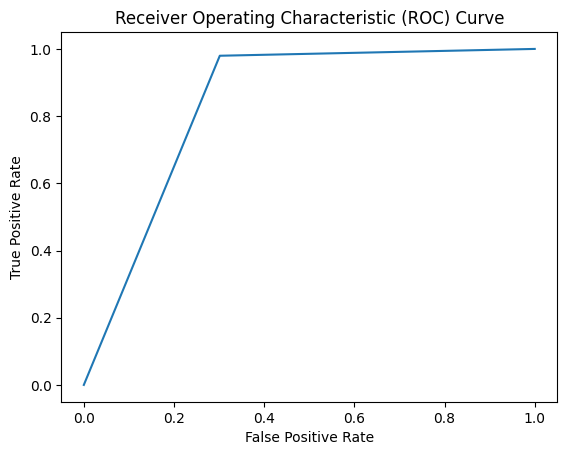

In [19]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

In [20]:
print("AUC:", auc)

AUC: 0.8390625


### Accuracy

In [21]:
correct = 0
total = 0
with torch.no_grad():
    for batch,(x,y) in enumerate(test_dataloader):
      x,y = x.to(device),y.to(device)
      outputs = model_0(x)
      _, predicted = torch.max(outputs.data, 1)
      total += y.size(0)
      correct += (predicted == y).sum().item()

In [22]:
accuracy = correct / total
print(f"Accuracy: {accuracy}")

Accuracy: 0.8390625


In [23]:
cm = confusion_matrix(true_labels, predictions)

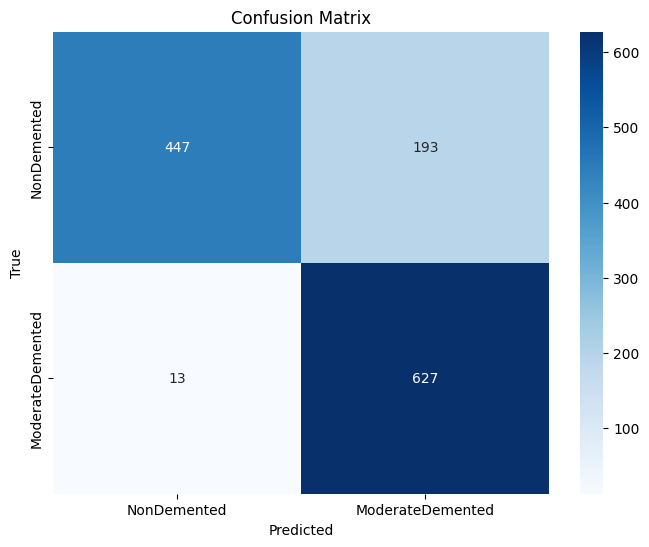

In [24]:
labels = ['NonDemented','ModerateDemented']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [25]:
true_positives = cm.diagonal()
false_positives = cm.sum(axis=0) - true_positives
false_negatives = cm.sum(axis=1) - true_positives
true_negatives = cm.sum() - (true_positives + false_positives + false_negatives)

In [26]:
accuracy = (true_positives + true_negatives) / cm.sum()
precision = true_positives / (true_positives + false_positives)

print("Accuracy:", accuracy)
print("Precision:", precision)

Accuracy: [0.8390625 0.8390625]
Precision: [0.97173913 0.76463415]


### Loss Curve

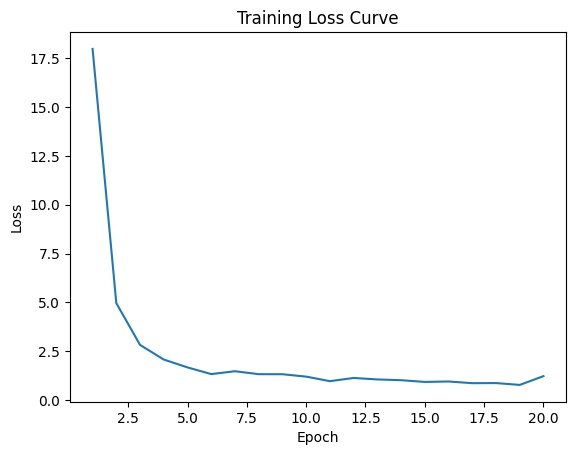

In [27]:
plt.plot(range(1, NUM_EPOCHS+1), model_0_results['train_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

### Train & Test Accuracy

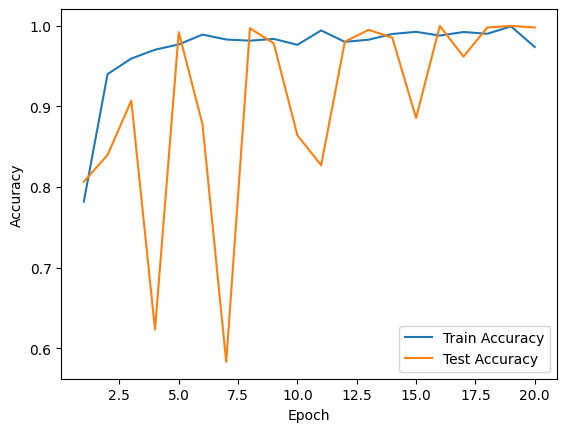

In [28]:
plt.plot(range(1, NUM_EPOCHS+1), model_0_results['train_acc'], label='Train Accuracy')
plt.plot(range(1, NUM_EPOCHS+1), model_0_results['test_acc'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

___

## Fourier Bessel Transform

In [14]:
from scipy.fftpack import dct, idct
from scipy.special import jn, jn_zeros

In [32]:
def fourier_bessel_transform(img):
    img_np = np.array(img)
    c, h, w = img_np.shape
    freq_r = np.fft.fftfreq(h) * h
    freq_r = np.fft.fftshift(freq_r)
    freq_a = np.arange(w) - (w // 2)
    bessel_zeros = jn_zeros(0, c)
    img_transformed = np.zeros((c, h, w), dtype=np.complex64)
    for i in range(c):
        for j in range(h):
            for k in range(w):
                r = freq_r[j]
                a = freq_a[k]
                img_transformed[i, j, k] = np.sum(img_np[i] * jn(0, bessel_zeros[i] * r) * np.exp(1j * a * r))
    img_transformed = torch.from_numpy(img_transformed.real)
    return img_transformed

# def fourier_bessel_transform(image):
#     f_size = 25
#     transformed_channels = []
#     for i in range(3):
#         rgb_fft = np.fft.fftshift(np.fft.fft2((image[:, :, i])))
#         rgb_fft[:225, 235:237] = 1
#         rgb_fft[-225:,235:237] = 1
#         transformed_channels.append(abs(np.fft.ifft2(rgb_fft)))

#     final_image = np.dstack([transformed_channels[0].astype(int),
#                              transformed_channels[1].astype(int),
#                              transformed_channels[2].astype(int)])
#     return final_image

In [15]:
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/Career/Research papers/alzheimers/Alzheimer_s Dataset/train', transform=transform)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/Career/Research papers/alzheimers/Alzheimer_s Dataset/test', transform=transform)

In [16]:
len(train_dataset)

5120

In [33]:
transformed_dataset = []
i=1
for image, _ in train_dataset:
    transformed_image = fourier_bessel_transform(image)
    transformed_dataset.append(transformed_image)
    print('{}/{} image done.'.format(i,len(train_dataset)))
    i+=1
    if i==5: break
transformed_dataset = torch.stack(transformed_dataset)

1/5120 image done.
2/5120 image done.
3/5120 image done.
4/5120 image done.


In [17]:
train_size = int(0.8 * len(train_dataset))
validation_size = len(train_dataset) - train_size

In [ ]:
train_size = int(0.8 * len(transformed_dataset))
validation_size = len(transformed_dataset) - train_size

In [23]:
training_dataset, validation_dataset = torch.utils.data.random_split(transformed_dataset, [train_size, validation_size])

In [18]:
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=training_dataset,batch_size=BATCH_SIZE,num_workers=os.cpu_count(),shuffle=True)
validation_dataloader = DataLoader(dataset=validation_dataset,batch_size=BATCH_SIZE,num_workers=os.cpu_count(),shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,num_workers=os.cpu_count(),shuffle=True)

In [19]:
BATCH_SIZE = 1
transformed_dataloader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,num_workers=os.cpu_count(),shuffle=True)

In [47]:
# print(transformed_dataset)
print(train_dataset)

Dataset ImageFolder
    Number of datapoints: 5120
    Root location: /content/drive/MyDrive/Career/Research papers/alzheimers/Alzheimer_s Dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(176, 176), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [49]:
for batch, (X, y) in enumerate(train_dataloader):
  X, y = X.to(device), y.to(device)
  print(y)

tensor([0], device='cuda:0')
tensor([1], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([0], device='cuda:0')
tensor([1], device='cuda:0')
tensor([0], device='cuda:0')
tensor([1], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([1], device='cuda:0')
tensor([0], device='cuda:0')
tensor([1], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([1], device='cuda:0')
tensor([0], device='cuda:0')
tensor([1], device='cuda:0')
tensor([0], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([0], device='cuda:0')
tensor([1], device='cuda:0')
tensor([0], device='cuda:0')
tensor([1], de

KeyboardInterrupt: ignored

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 100

model_1 = DEMNet(num_classes=2).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=1e-3)

start_time = timer()

model_1_results = train(model_1, transformed_dataloader, validation_dataloader, optimizer, loss_fn, NUM_EPOCHS, device)

end_time = timer()

print(f"Time Taken: {(end_time - start_time) / 60:.2f} mins")

  0%|          | 0/100 [00:00<?, ?it/s]

ValueError: ignored